In [1]:
#load up the basics
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#image file issue
#https://stackoverflow.com/questions/48395076/keras-giving-oserror-image-file-is-truncated-26-bytes-not-processed
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None


#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import TF stuff
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model


#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")
    


TF version: 2.3.2
 GPU: /device:GPU:0


In [2]:
# build the generator build data generators for training and validaton

# here are the numbers for each storms, if we want to break those out for par. processing.
#(vs. running entire dir of all storms).
# Barry, 8900
# Delta, 9785
# Dorian, 24749
# Florence, 31434
# Gordon, 2019
# Isaias, 8938
# Laura, 24165
# Michael, 9600
# Sally, 6390
# Zeta, 8644
# pred_data_dir = '/data/NOAA_ERI/Florence'


# Define dirs and files
train_data_dir = '/data/NOAA_ERI/'

split = 0.2

total_train = 108200
total_val = 27045



# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 32

#latent_dim
z_dim = 200

#set Image size (RGB so imshape is 3)
pix_dim = 512
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'input',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'input',
                                                        target_size = imsize,
                                                        subset='validation')

# define the metrics
#acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

Found 108200 images belonging to 13 classes.
Found 27045 images belonging to 13 classes.


In [3]:
#load or build model
##########

input = layers.Input(imshape)

x = layers.Conv2D(32, (3,3), strides=2, activation = "relu", padding = "same")(input)
x = layers.Conv2D(32, (3,3), strides=2, activation = "relu", padding = "same")(x)
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(x)

x = layers.Flatten()(x)
x = layers.Dense(z_dim)(x)

x = layers.Dense(32*32*32, activation = "relu")(x)
x = layers.Reshape((32,32,32))(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(3,3, activation = "sigmoid", padding = "same")(x)



autoencoder = Model(input,x)
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy")
autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 200)              

In [4]:
# define a callback

the_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./models/AE200_checkpoint_{epoch:02d}-{val_loss:.2f}.h5')]

In [9]:
#filepath = './models/AE200_checkpoint_06-0.58.h5'
#load model
#autoencoder = tf.keras.models.load_model(filepath, compile = True)

In [5]:
workfolk = 24

history = autoencoder.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 5,
                    validation_steps =  total_val // batch_size,
                    workers = workfolk,
                    max_queue_size = 6 * workfolk,
                    callbacks = the_callbacks)


Epoch 1/5
3381/3381 [==============================] - 3408s 1s/step - loss: 0.5831 - val_loss: 0.5811
Epoch 2/5
3381/3381 [==============================] - 3423s 1s/step - loss: 0.5792 - val_loss: 0.5803
Epoch 3/5
3381/3381 [==============================] - 3402s 1s/step - loss: 0.5788 - val_loss: 0.5802
Epoch 4/5
3381/3381 [==============================] - 3449s 1s/step - loss: 0.5785 - val_loss: 0.5799
Epoch 5/5
3381/3381 [==============================] - 3470s 1s/step - loss: 0.5784 - val_loss: 0.5798


In [6]:
#test model

def ShowAEResult(im):
    img = tf.keras.preprocessing.image.load_img(im,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)

    predicted = autoencoder.predict(img)


    fig = plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(tf.keras.preprocessing.image.load_img(im, target_size = imsize))
    plt.subplot(122)
    plt.imshow(np.squeeze(predicted))

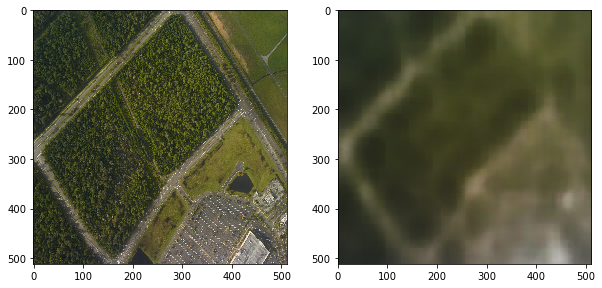

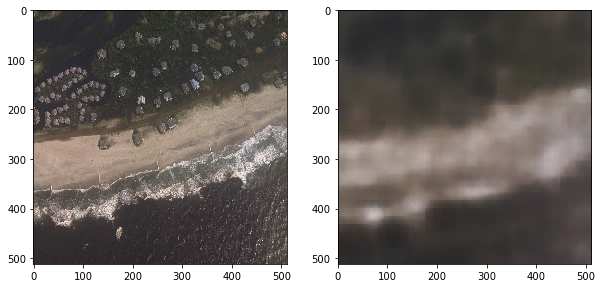

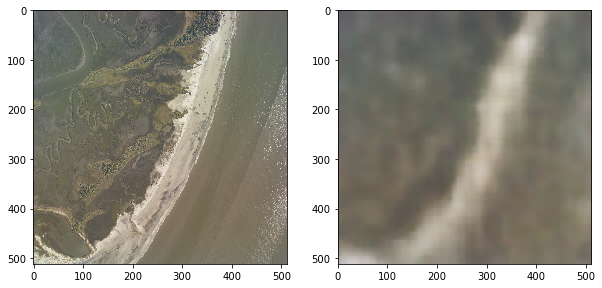

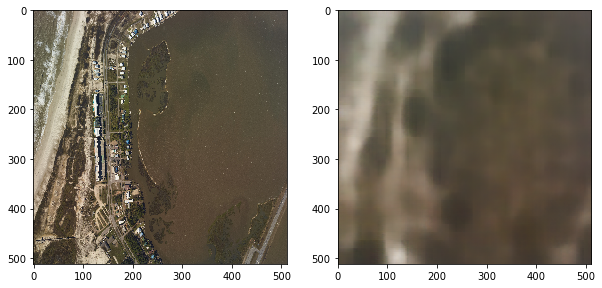

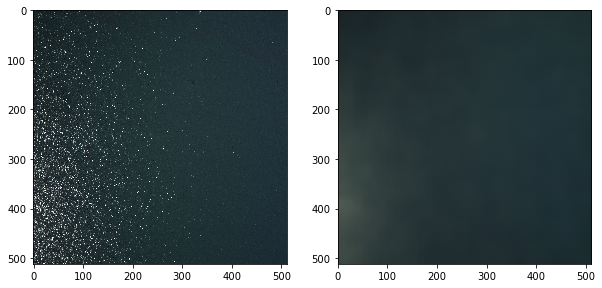

In [7]:
# examples from Florence, Dorian, Zeta, 
ShowAEResult("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048812.jpg")
ShowAEResult("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055088.jpg")
ShowAEResult("/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952838.jpg")
ShowAEResult("/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360377.jpg")
ShowAEResult("/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018922-0824211724470-RGB2.jpg")

In [8]:
#save the model
filepath = './models/Autoencoder200'
autoencoder.save(filepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/Autoencoder200/assets


In [9]:
#remove the decoder
encoder = tf.keras.models.Sequential(autoencoder.layers[:-7])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               6553800   
Total params: 6,582,440
Trainable params: 6,582,440
Non-trainable params: 0
______________________________________________

In [10]:
#Test to see if its working

im = "/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952838.jpg"
img = tf.keras.preprocessing.image.load_img(im,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img,axis=0)


Dims = encoder.predict(img)
print(Dims)

[[-5.02987385e-01 -5.01271129e-01 -6.14344478e-01 -1.26055193e+00
   1.42368495e-01  1.24807823e+00 -1.55718088e-01  5.82374215e-01
   1.62474886e-01 -3.44002753e-01  2.08409801e-01  2.14978862e+00
   1.16794014e+00 -9.80250835e-01  8.85932148e-01  3.55623096e-01
  -3.33182484e-01 -1.34361875e+00  1.36924434e+00  1.44480407e-01
  -7.70150304e-01 -5.33551931e-01 -1.02689350e+00 -3.23633105e-01
   1.50929856e+00 -1.64941445e-01  5.97081780e-01  4.15396154e-01
  -1.36213839e+00 -1.23527825e+00 -6.81465149e-01 -2.16808289e-01
   1.02874327e+00  4.35825765e-01 -8.98608685e-01  2.32739434e-01
  -1.04617810e+00 -9.14417028e-01  1.45384145e+00  6.90457344e-01
  -1.48689270e+00  1.49974257e-01 -3.15437496e-01 -1.47653356e-01
  -1.95290297e-01  1.81735766e+00 -7.84166336e-01  7.31962204e-01
   6.09554827e-01  1.04991806e+00  7.80181050e-01 -1.43638298e-01
  -1.34294307e+00  1.80890858e-01  7.58211076e-01  1.02329898e+00
   1.11090934e+00 -2.22272277e-01 -1.82083762e+00  1.45508420e+00
  -7.58020